In [1]:
import os 
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import string
import nltk
from collections import Counter
from spacy.lang.en import English
from nltk.util import bigrams, trigrams
from itertools import chain

# Load the dictonary in English and Portuguese
spacy.load("en_core_web_sm")

# Define function to cleanup text by removing 
# personal pronouns, stopwords, and puncuation
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation

# Datasets
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, 'data/rebirth-remains.csv')

# Load file
df_raw_lyrics = pd.read_csv(filename, index_col=False)
df_raw_lyrics.columns = ['index','artist','album','lyric']

# Backup to not use the Google API to get the language again
# PS: I know... it sucks, but this is what we have for today)
df = df_raw_lyrics

# Basic counters
print(f'Qty rows: {df_raw_lyrics.shape[0]}, Qty columns: {df_raw_lyrics.shape[1]}')

# First look in the data
df_raw_lyrics.head(5)

Qty rows: 372, Qty columns: 4


,index,artist,album,lyric
0,0,sepultura,Bestial Devastation,"The curse is launched, beware\nThe Lord of Dea..."
1,1,sepultura,Bestial Devastation,A legion of demons\nBorn from boundaries of de...
2,2,sepultura,Bestial Devastation,Born from Hell\nThe supreme force of evil\nTo ...
3,3,sepultura,Bestial Devastation,The misfits high in this night\nCan feel the p...
4,4,sepultura,Bestial Devastation,Marching over the mist\nLeaving behind the wea...


In [2]:
# One limitation of the wrapper that I used to get the data
# it's that contains a lot of bad records
df_raw_lyrics = df_raw_lyrics[pd.notnull(df_raw_lyrics['lyric'])]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("<span style=")]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("padding")]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("<img")]

In [3]:
# Basic counters
print(f'Qty rows: {df_raw_lyrics.shape[0]}, Qty columns: {df_raw_lyrics.shape[1]}')

Qty rows: 325, Qty columns: 4


In [4]:
# One of the main challenges it's that these bands 
# usually write songs in multi-language (EN and PT-BR)
# For a matter of simplicity we'll concentrate only in the 
# EN language.

# The main idea is: get only EN songs

# Wrapper that use Google API to 
# check the language. Use carefully
# because the Google API returns 
# the code "HTTP too many requests"
# if you run twice
def get_language(text):
    from textblob import TextBlob
    text = str(text)
    b = TextBlob(text)
    return b.detect_language()

# Include language in the DF
df_raw_lyrics['lang'] = df_raw_lyrics['lyric'].apply(get_language)

In [5]:
# Show stats about the language per artist
df_raw_lyrics.groupby(['artist', 'lang']).size().reset_index()

,artist,lang,0
0,angra,en,119
1,angra,pt,4
2,sepultura,en,194
3,sepultura,ja,1
4,sepultura,pt,7


In [6]:
# Filtering out non-EN songs
df_raw_lyrics = df_raw_lyrics[df_raw_lyrics['lang'] == 'en']

In [7]:
# Qty of songs per artist
df_raw_lyrics.groupby(['artist']).size().reset_index()

,artist,0
0,angra,119
1,sepultura,194


In [8]:
# Lyrics per album
df_raw_lyrics.groupby(['artist', 'album']).size().reset_index()

,artist,album,0
0,angra,Angels Cry,9
1,angra,Aqua,10
2,angra,Aurora Consurgens,11
3,angra,Fireworks,11
4,angra,Freedom Call,8
5,angra,Holy Land,10
6,angra,Holy Live,4
7,angra,Hunters and Prey,7
8,angra,Omni,10
9,angra,Reaching Horizons,9


In [9]:
# Average songs per album
df_albuns = df_raw_lyrics.groupby(['artist', 'album']).size().reset_index()
df_albuns.columns = ['artist', 'album', 'qty_tracks']
df_albuns.groupby(['artist']).agg({'qty_tracks': [np.size, np.mean]}).reset_index()

artist qty_tracks           
                   size       mean
0      angra         13   9.153846
1  sepultura         18  10.777778

In [10]:
# Convert the lyrics to String to not break the posterior convertions
df_raw_lyrics['lyric'] = df_raw_lyrics['lyric'].astype(str)

In [11]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Remove all stopwords
df_raw_lyrics['lyric'] = df_raw_lyrics['lyric'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [12]:
# Quick check
df_raw_lyrics.head(5)

,index,artist,album,lyric,lang
0,0,sepultura,Bestial Devastation,"The curse launched, beware The Lord Death decl...",en
1,1,sepultura,Bestial Devastation,A legion demons Born boundaries death Like ons...,en
2,2,sepultura,Bestial Devastation,Born Hell The supreme force evil To destroy al...,en
3,3,sepultura,Bestial Devastation,The misfits high night Can feel presence death...,en
4,4,sepultura,Bestial Devastation,Marching mist Leaving behind weakest Going end...,en


In [16]:
# Data exploration in some specific class to see the most frequent words
def get_word_frequency(artist):
    from nltk.corpus import stopwords
    stoplist = set(stopwords.words("english"))

    # Word Frequency per Category
    def cleanup_text(docs, logging=False):
        texts = []
        counter = 1
        for doc in docs:
            if counter % 1000 == 0 and logging:
                print("Processed %d out of %d documents." % (counter, len(docs)))
            counter += 1
            doc = nlp(doc, disable=['parser', 'ner'])
            tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
            tokens = [tok for tok in tokens if tok not in stoplist and tok not in punctuations]
            tokens = ' '.join(tokens)
            texts.append(tokens)
        return pd.Series(texts)

    df_text = [text for text in df_raw_lyrics[df_raw_lyrics['artist'] == artist]['lyric']]
    df_text_clean = cleanup_text(df_text)
    df_text_clean = ' '.join(df_text_clean).split()
    df_text_clean_counts = Counter(df_text_clean)
    df_common_words = [word[0] for word in df_text_clean_counts.most_common(31)]
    df_common_counts = [word[1] for word in df_text_clean_counts.most_common(31)]
    df_common_words.pop(0)
    df_common_counts.pop(0)

    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=df_common_words, y=df_common_counts)
    plt.title(f'Most Common Words used in {artist} category')
    plt.xticks(rotation=45)
    plt.show()

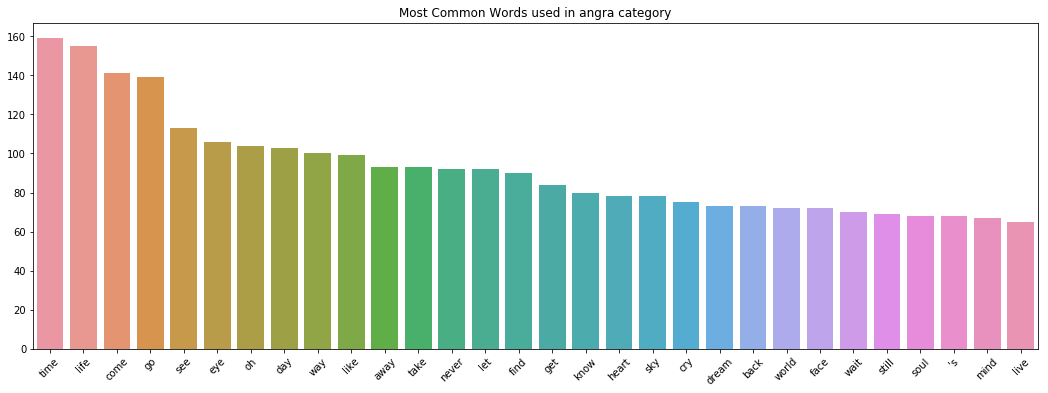

In [17]:
get_word_frequency('angra')

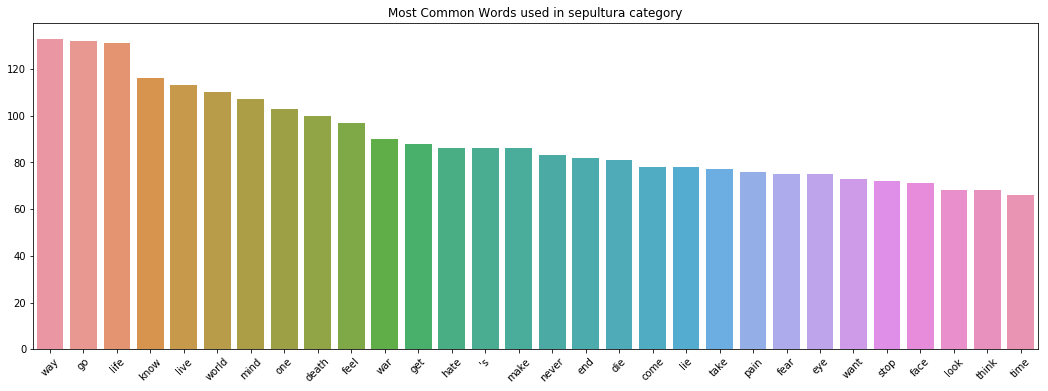

In [18]:
get_word_frequency('sepultura')

In [19]:
# Word cloud with most common words
def show_wordcloud(text, artist):
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    
    from nltk.corpus import stopwords
    STOPLIST = set(stopwords.words('english'))

    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=STOPLIST, background_color="white").generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(25,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for the {artist} category', fontsize=20)
    plt.axis("off")
    plt.show()
    
def get_wordcloud(df, artist):
    dataframe = df[df['artist'] == artist]
    # Get all texts and generate a cloud
    text = " ".join(review for review in dataframe.lyric)
    show_wordcloud(text, artist) 

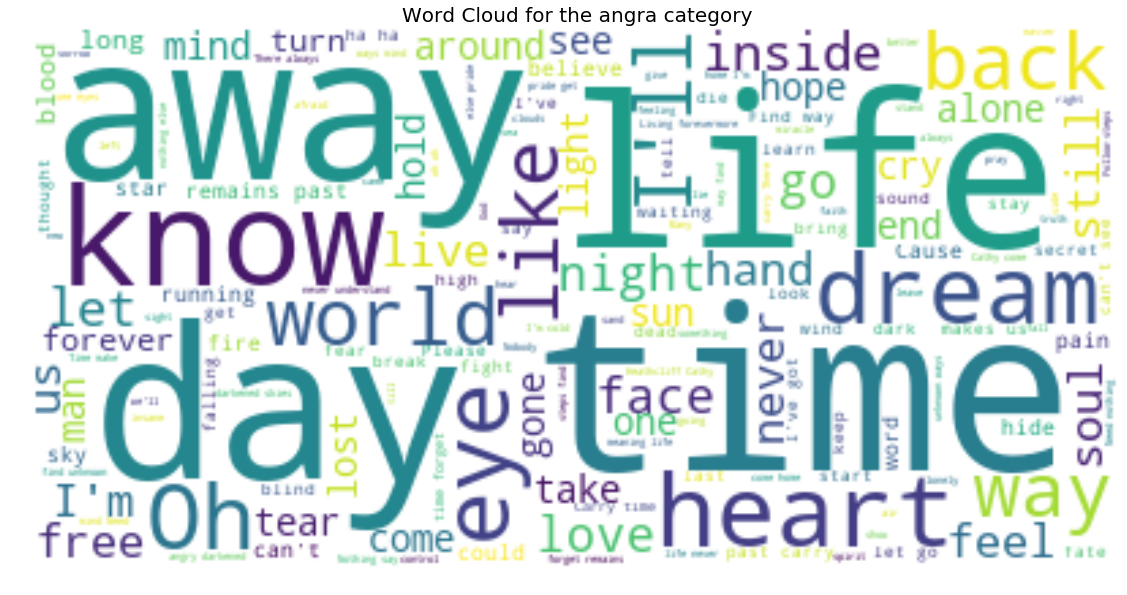

In [20]:
get_wordcloud(df_raw_lyrics, 'angra')

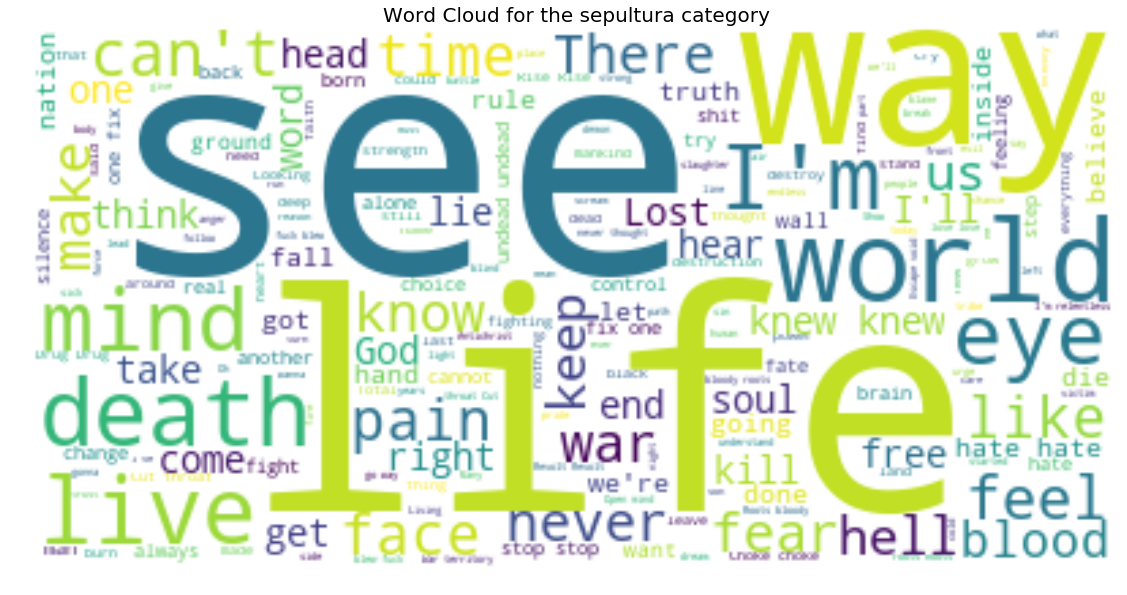

In [21]:
get_wordcloud(df_raw_lyrics, 'sepultura')

In [22]:
def get_lexical_diversity(df, artist):
    dataframe = df[df['artist'] == artist]

    full_text_count = pd.DataFrame(Counter(" ".join(dataframe["lyric"]).split()), index=[0])
    full_text_count = full_text_count.T
    full_text_count = full_text_count.reset_index()
    full_text_count.columns = ['word', 'qty']

    distinct_words = set()
    dataframe['lyric'].str.lower().str.split().apply(distinct_words.update)
    total_distinct_words = len(distinct_words)

    total_words = full_text_count['qty'].sum()

    lexical_diversity = round((total_distinct_words / total_words),2)

    print(artist, lexical_diversity)
    
    return artist, lexical_diversity

In [23]:
get_lexical_diversity(df_raw_lyrics, 'angra')

angra 0.19


('angra', 0.19)

In [24]:
get_lexical_diversity(df_raw_lyrics, 'sepultura')

sepultura 0.2


('sepultura', 0.2)

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

def get_word_ngrams_list(df, artist, word_ngram):

    def get_top_word_n_bigram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(word_ngram, word_ngram)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]


    common_words = get_top_word_n_bigram(df[df['artist'] == artist]['lyric'], 20)
    df3 = pd.DataFrame(common_words, columns = ['desc' , 'count'])

    return df3

In [26]:
get_word_ngrams_list(df_raw_lyrics, 'angra', 2)

,desc,count
0,carry on,29
1,the remains,24
2,remains past,24
3,we re,24
4,ve got,23
5,ha ha,19
6,makes us,18
7,me cathy,18
8,you re,18
9,find way,18


In [27]:
get_word_ngrams_list(df_raw_lyrics, 'angra', 3)

,desc,count
0,the remains past,24
1,carry on time,16
2,on time forget,16
3,time forget the,16
4,forget the remains,16
5,remains past carry,16
6,angry darkened skies,16
7,heathcliff me cathy,16
8,me cathy come,16
9,cathy come home,16


In [28]:
get_word_ngrams_list(df_raw_lyrics, 'sepultura', 2)

,desc,count
0,we re,48
1,no no,48
2,knew don,28
3,stop me,27
4,undead undead,24
5,one fix,24
6,me stop,21
7,choke choke,21
8,hate you,20
9,you hate,20


In [29]:
get_word_ngrams_list(df_raw_lyrics, 'sepultura', 3)

,desc,count
0,no no no,35
1,undead undead undead,22
2,stop me stop,21
3,hate you hate,20
4,roots bloody roots,16
5,knew it knew,16
6,don that knew,16
7,cut throat cut,15
8,throat cut throat,15
9,just one fix,15


In [30]:
# LDA Analysis
df_raw_lyrics_angra = df_raw_lyrics[df_raw_lyrics['artist'] == 'angra']
df_raw_lyrics_sepultura = df_raw_lyrics[df_raw_lyrics['artist'] == 'sepultura']

In [220]:
def get_topics(df, n_components, number_words):
    # Convert to list
    data = df.lyric.values.tolist()

    # Remove special characters
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    vectorizer = CountVectorizer(analyzer='word',       
                                 min_df=10,                        # minimum reqd occurences of a word 
                                 stop_words='english',             # remove stop words
                                 lowercase=True,                   # convert all words to lowercase
                                 token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                                 # max_features=50000,             # max number of uniq words
                                )

    data_vectorized = vectorizer.fit_transform(data)

    # Materialize the sparse data
    data_dense = data_vectorized.todense()

    # Compute Sparsicity = Percentage of Non-Zero cells
    print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

    # Build LDA Model
    from sklearn.decomposition import LatentDirichletAllocation

    lda_model = LatentDirichletAllocation(n_components=n_components,               # Number of topics
                                          max_iter=10,               # Max learning iterations
                                          learning_method='online',   
                                          random_state=100,          # Random state
                                          batch_size=128,            # n docs in each learning iter
                                          evaluate_every = -1, # compute perplexity every n iters, default: Don't
                                          n_jobs = -1,               # Use all available CPUs
                                         )
    lda_output = lda_model.fit_transform(data_vectorized)

    # Helper function
    def print_topics(model, count_vectorizer, n_top_words):
        words = count_vectorizer.get_feature_names()
        for topic_idx, topic in enumerate(model.components_):
            print("\nTopic #%d:" % topic_idx)
            print(" ".join([words[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]]))

    # Print the topics found by the LDA model
    print("Topics found via LDA:")
    lda_model.fit(data_vectorized)

    print_topics(lda_model, vectorizer, number_words)
    
    return lda_model, data_vectorized, data, lda_output, vectorizer

In [222]:
lda_model_angra, data_vectorized_angra, data_angra, lda_output_angra, vectorizer_angra = get_topics(df_raw_lyrics_angra,
                                                                                  n_components=10,
                                                                                  number_words=10)

Sparsicity:  15.233207376910496 %
Topics found via LDA:

Topic #0:
time sun way world dont end day dream cause light

Topic #1:
away feel know like secrets close soul heart theres turn

Topic #2:
freedom better ground right cold blood hands dying words blind

Topic #3:
time life eyes day ill way inside away know heart

Topic #4:
soul ive heart eyes waiting like lives ill words fate

Topic #5:
life angels time theres past remains skies try lies mind

Topic #6:
let come away cold say land long ive face got

Topic #7:
world like deep love sky land waiting wonder close dead

Topic #8:
light end die come angels eyes hold dreams hide came

Topic #9:
like life understand face eyes mind standing let forever little


In [223]:
lda_model_sepultura, data_vectorized_sepultura, data_sepultura, lda_output_sepultura, vectorizer_sepultura = get_topics(df_raw_lyrics_sepultura,
                                                                                                  n_components=10,
                                                                                                  number_words=10)

Sparsicity:  9.748140414981078 %
Topics found via LDA:

Topic #0:
life live way believe mind born fear bloody lies day

Topic #1:
love hate nation destruction eyes mankind gods wrong come change

Topic #2:
dont know fuck like try wrong shit whats think face

Topic #3:
death blood hell pain inside ive feel living war world

Topic #4:
end world war eyes dead fight right free alive theres

Topic #5:
stop like dead world ill mind cause way death open

Topic #6:
time sight force trust got minds thats right black tell

Topic #7:
lost false life cause regret coming mind feel hell end

Topic #8:
way look away world just lost walk die theres face

Topic #9:
want make thought die need let live away got going


In [194]:
def get_topic_per_document(lda_model, data_vectorized, data, lda_output):
    # Create Document - Topic Matrix
    lda_output = lda_model.transform(data_vectorized)

    # column names
    topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

    # index names
    docnames = ["Doc" + str(i) for i in range(len(data))]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic

    # Styling
    def color_green(val):
        color = 'green' if val > .1 else 'black'
        return 'color: {col}'.format(col=color)

    def make_bold(val):
        weight = 700 if val > .1 else 400
        return 'font-weight: {weight}'.format(weight=weight)

    # Apply Style
    df_document_topics_styled = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
    
    return df_document_topics_styled, df_document_topic

In [195]:
df_topic_per_document_angra_styled, df_topic_per_document_angra = get_topic_per_document(lda_model_angra,
                                                                                         data_vectorized_angra,
                                                                                         data_angra,
                                                                                         lda_output_angra)
df_topic_per_document_angra_styled

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0,0,0,0,0.99,0,0,0,0,5
Doc1,0,0,0,0.99,0,0,0,0,0,0,3
Doc2,0,0,0,0,0,0.99,0,0,0,0,5
Doc3,0,0,0,0,0,0,0.98,0,0,0,6
Doc4,0,0,0,0,0,0,0,0,0,0.98,9
Doc5,0,0,0,0,0,0,0.98,0,0,0,6
Doc6,0,0,0,0.54,0,0.25,0.2,0,0,0,3
Doc7,0.99,0,0,0,0,0,0,0,0,0,0
Doc8,0.01,0.94,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
Doc9,0,0,0,0,0,0,0.98,0,0,0,6


In [196]:
df_topic_per_document_sepultura_styled, df_topic_per_document_sepultura = get_topic_per_document(lda_model_sepultura,
                                                                                                 data_vectorized_sepultura,
                                                                                                 data_sepultura,
                                                                                                 lda_output_sepultura)
df_topic_per_document_sepultura_styled

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.03,0.03,0.03,0.77,0.03,0.03,0.03,0.03,0.03,0.03,3
Doc1,0.01,0.01,0.01,0.22,0.01,0.74,0.01,0.01,0.01,0.01,5
Doc2,0,0,0,0.13,0,0.83,0,0,0,0,5
Doc3,0,0,0,0.96,0,0,0,0,0,0,3
Doc4,0.01,0.01,0.01,0.01,0.01,0.9,0.01,0.01,0.01,0.01,5
Doc5,0.01,0.24,0.01,0.71,0.01,0.01,0.01,0.01,0.01,0.01,3
Doc6,0,0,0,0.98,0,0,0,0,0,0,3
Doc7,0,0.29,0,0.68,0,0,0,0,0,0,3
Doc8,0,0,0,0.98,0,0,0,0,0,0,3
Doc9,0,0.37,0,0.31,0,0.23,0,0.08,0,0,1


In [211]:
def get_topic_distribution(df_document_topic):
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    total_docs = df_topic_distribution['Num Documents'].sum()
    df_topic_distribution['perc_per_topic'] = np.round(((df_topic_distribution['Num Documents'] /total_docs) * 100), 2)

    return df_topic_distribution

In [212]:
get_topic_distribution(df_topic_per_document_angra)

,Topic Num,Num Documents,perc_per_topic
0,3,41,34.45
1,4,18,15.13
2,5,16,13.45
3,6,12,10.08
4,7,9,7.56
5,1,8,6.72
6,9,5,4.20
7,0,5,4.20
8,8,4,3.36
9,2,1,0.84


In [213]:
get_topic_distribution(df_topic_per_document_sepultura)

,Topic Num,Num Documents,perc_per_topic
0,8,40,20.62
1,3,36,18.56
2,0,36,18.56
3,5,24,12.37
4,4,12,6.19
5,2,11,5.67
6,1,10,5.15
7,6,9,4.64
8,9,8,4.12
9,7,8,4.12


In [242]:
def get_word_topics(vectorizer, lda_model):

    # Show top n keywords for each topic
    def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
        keywords = np.array(vectorizer.get_feature_names())
        topic_keywords = []
        for topic_weights in lda_model.components_:
            top_keyword_locs = (-topic_weights).argsort()[:n_words]
            topic_keywords.append(keywords.take(top_keyword_locs))
        return topic_keywords

    topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

    return df_topic_keywords

In [243]:
get_word_topics(vectorizer_angra, lda_model_angra)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,time,sun,way,world,dont,end,day,dream,cause,light
Topic 1,away,feel,know,like,secrets,close,soul,heart,theres,turn
Topic 2,freedom,better,ground,right,cold,blood,hands,dying,words,blind
Topic 3,time,life,eyes,day,ill,way,inside,away,know,heart
Topic 4,soul,ive,heart,eyes,waiting,like,lives,ill,words,fate
Topic 5,life,angels,time,theres,past,remains,skies,try,lies,mind
Topic 6,let,come,away,cold,say,land,long,ive,face,got
Topic 7,world,like,deep,love,sky,land,waiting,wonder,close,dead
Topic 8,light,end,die,come,angels,eyes,hold,dreams,hide,came
Topic 9,like,life,understand,face,eyes,mind,standing,let,forever,little


In [244]:
get_word_topics(vectorizer_sepultura, lda_model_sepultura)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,life,live,way,believe,mind,born,fear,bloody,lies,day
Topic 1,love,hate,nation,destruction,eyes,mankind,gods,wrong,come,change
Topic 2,dont,know,fuck,like,try,wrong,shit,whats,think,face
Topic 3,death,blood,hell,pain,inside,ive,feel,living,war,world
Topic 4,end,world,war,eyes,dead,fight,right,free,alive,theres
Topic 5,stop,like,dead,world,ill,mind,cause,way,death,open
Topic 6,time,sight,force,trust,got,minds,thats,right,black,tell
Topic 7,lost,false,life,cause,regret,coming,mind,feel,hell,end
Topic 8,way,look,away,world,just,lost,walk,die,theres,face
Topic 9,want,make,thought,die,need,let,live,away,got,going


In [254]:
def get_LDA_plot(lda_model, data_vectorized, vectorizer):
    import pyLDAvis
    import pyLDAvis.sklearn
    %matplotlib inline

    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
    return panel

In [255]:
get_LDA_plot(lda_model_angra, data_vectorized_angra, vectorizer_angra)

/Users/flavio.desouza/Documents/text-classification-spacy/text-classification-spacy/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -312.992462 -177.986420       1        1  29.321293
5     -124.274887   79.258972       2        1  18.518784
6     -410.211639  118.178658       3        1  12.325991
4     -237.236343  377.520660       4        1  12.250156
7      319.684052  301.526794       5        1   7.092356
1      130.947891   44.427467       6        1   5.608018
9      -35.794453 -224.951508       7        1   5.380683
0       42.479206  348.716705       8        1   5.259500
8      243.853363 -253.975494       9        1   3.693008
2      416.857300    5.324873      10        1   0.550211, topic_info=    Category        Freq        Term       Total  loglift  logprob
75   Default   54.000000       light   54.000000  30.0000  30.0000
72   Default   80.000000         let   80.000000  29.0000  29.0000
4    Default   86.000000        away   86.000000  28.0000  28.0000
2    Default   57.000000      angels   57.000000  27.0000  27.0000
45   Default   18.000000     freedom   18.000000  26.0000  26.0000
76   Default   91.000000        like   91.000000  25.0000  25.0000
74   Default  133.000000        life  133.000000  24.0000  24.0000
133  Default  141.000000        time  141.000000  23.0000  23.0000
148  Default   66.000000       world   66.000000  22.0000  22.0000
125  Default   43.000000         sun   43.000000  21.0000  21.0000
6    Default   17.000000      better   17.000000  20.0000  20.0000
39   Default   39.000000        feel   39.000000  19.0000  19.0000
31   Default   33.000000         end   33.000000  18.0000  18.0000
15   Default   29.000000        cold   29.000000  17.0000  17.0000
16   Default   76.000000        come   76.000000  16.0000  16.0000
35   Default   24.000000     falling   24.000000  15.0000  15.0000
30   Default   23.000000       dying   23.000000  14.0000  14.0000
32   Default  105.000000        eyes  105.000000  13.0000  13.0000
118  Default   56.000000        soul   56.000000  12.0000  12.0000
104  Default   26.000000       right   26.000000  11.0000  11.0000
86   Default   43.000000        love   43.000000  10.0000  10.0000
147  Default   20.000000       words   20.000000   9.0000   9.0000
69   Default   37.000000        land   37.000000   8.0000   8.0000
8    Default   24.000000       blood   24.000000   7.0000   7.0000
24   Default   24.000000        deep   24.000000   6.0000   6.0000
137  Default   19.000000  understand   19.000000   5.0000   5.0000
25   Default   28.000000         die   28.000000   4.0000   4.0000
73   Default   38.000000        lies   38.000000   3.0000   3.0000
56   Default   61.000000       heart   61.000000   2.0000   2.0000
53   Default   22.000000       hands   22.000000   1.0000   1.0000
..       ...         ...         ...         ...      ...      ...
13   Topic10    0.160229       close   17.733809   0.4960  -5.0744
0    Topic10    0.141695      afraid   15.804266   0.4883  -5.1974
105  Topic10    0.148288         run   16.666630   0.4806  -5.1519
58   Topic10    0.120635      hidden   13.582456   0.4789  -5.3583
20   Topic10    0.146840        dawn   16.856512   0.4595  -5.1617
134  Topic10    0.127359    tomorrow   14.683742   0.4551  -5.3040
95   Topic10    0.150729        ones   17.442681   0.4514  -5.1356
54   Topic10    0.137065        hard   15.873918   0.4506  -5.2306
9    Topic10    0.129683       break   15.217950   0.4375  -5.2859
82   Topic10    0.142367      lonely   16.753202   0.4347  -5.1926
91   Topic10    0.136653     morning   16.115110   0.4326  -5.2336
14   Topic10    0.140190      clouds   16.582996   0.4295  -5.2080
81   Topic10    0.123743  loneliness   14.759504   0.4212  -5.3328
110  Topic10    0.133783     secrets   16.076468   0.4137  -5.2548
129  Topic10    0.144685      things   17.578089   0.4028  -5.1765
46   Topic10    0.156959      future   20.300129   0.3402  -5.0951
144  Topic10    0.153739        wind   20.187

In [256]:
get_LDA_plot(lda_model_sepultura, data_vectorized_sepultura, vectorizer_sepultura)

/Users/flavio.desouza/Documents/text-classification-spacy/text-classification-spacy/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
8     -324.515472  -13.353921       1        1  20.436083
3      -80.444275  -96.987549       2        1  16.437040
0      148.348526  -16.463001       3        1  15.552868
5       61.195976  373.203003       4        1  11.539892
7      -35.499599  141.655563       5        1   7.259408
2     -193.549850 -315.968628       6        1   6.579503
4      370.827698 -122.059799       7        1   6.487922
9      116.180405 -296.844849       8        1   6.425223
6     -252.355362  267.329895       9        1   5.159248
1      291.096802  197.815567      10        1   4.122813, topic_info=    Category        Freq         Term       Total  loglift  logprob
27   Default   86.000000         dont   86.000000  30.0000  30.0000
149  Default   64.000000         want   64.000000  29.0000  29.0000
139  Default   63.000000         time   63.000000  28.0000  28.0000
58   Default   68.000000         hate   68.000000  27.0000  27.0000
73   Default   63.000000         know   63.000000  26.0000  26.0000
129  Default   54.000000         stop   54.000000  25.0000  25.0000
89   Default   81.000000         lost   81.000000  24.0000  24.0000
29   Default   70.000000          end   70.000000  23.0000  23.0000
90   Default   32.000000         love   32.000000  22.0000  22.0000
22   Default   86.000000        death   86.000000  21.0000  21.0000
91   Default   46.000000         make   46.000000  20.0000  20.0000
21   Default   43.000000         dead   43.000000  19.0000  19.0000
33   Default   75.000000         eyes   75.000000  18.0000  18.0000
150  Default   70.000000          war   70.000000  17.0000  17.0000
37   Default   33.000000        false   33.000000  16.0000  16.0000
26   Default   62.000000          die   62.000000  15.0000  15.0000
83   Default   56.000000         like   56.000000  14.0000  14.0000
154  Default  115.000000        world  115.000000  13.0000  13.0000
137  Default   35.000000      thought   35.000000  12.0000  12.0000
97   Default   43.000000         need   43.000000  11.0000  11.0000
47   Default   33.000000         fuck   33.000000  10.0000  10.0000
84   Default   80.000000         live   80.000000   9.0000   9.0000
12   Default   45.000000        cause   45.000000   8.0000   8.0000
25   Default   24.000000  destruction   24.000000   7.0000   7.0000
111  Default   46.000000        right   46.000000   6.0000   6.0000
155  Default   34.000000        wrong   34.000000   5.0000   5.0000
63   Default   55.000000         hell   55.000000   4.0000   4.0000
78   Default   31.000000          let   31.000000   3.0000   3.0000
81   Default  119.000000         life  119.000000   2.0000   2.0000
45   Default   24.000000        force   24.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
58   Topic10   22.779284         hate   68.010785   2.0948  -2.2113
98   Topic10    4.553485          new   20.900736   1.6647  -3.8212
108  Topic10    5.014267        power   23.415775   1.6475  -3.7248
13   Topic10    5.544771       change   27.641337   1.5822  -3.6243
155  Topic10    6.202562        wrong   34.117089   1.4838  -3.5122
54   Topic10    2.666673        greed   15.087598   1.4556  -4.3563
16   Topic10    5.693390         come   35.631904   1.3547  -3.5978
85   Topic10    1.806506        lives   13.821741   1.1538  -4.7457
57   Topic10    2.732164        hands   21.819059   1.1109  -4.3320
115  Topic10    1.977702         said   16.877942   1.0446  -4.6552
33   Topic10    7.549662         eyes   75.558411   0.8852  -3.3156
138  Topic10    1.436157     thoughts   15.351077   0.8194  -4.9752
99   Topic10    1.467107        night   18.267397   0.6668  -4.9538
10   Topic10    1.314448       buried   17.078036   0.6243  -5.0637
82   Topic10    1.097204        light   14.409576   0.6135  -5.2444
30   Topic10    1.113385      endless   14.659559   0.6109  -5.22

In [ ]:
TODO
- Include track name
- Compare Sepultura Eras (Max - Derick)
- Compare Angra Eras (Mattos - Falaschi - Lioni)
- Similarity between Tracks (Content-based)
- Sepultura/Angra LSTM lyric generator
- Topic per album
- Topic evolution


References

Machine Learning Plus
LDA in Python – How to grid search best topic models?
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
    
Susan Li  
Building a Content Based Recommender System for Hotels in Seattle
https://towardsdatascience.com/building-a-content-based-recommender-system-for-hotels-in-seattle-d724f0a32070

Susan Li  
Automatically Generate Hotel Descriptions with LSTM    
https://towardsdatascience.com/automatically-generate-hotel-descriptions-with-lstm-afa37002d4fc
    
Shashank Kapadia
End-To-End Topic Modeling in Python: Latent Dirichlet Allocation (LDA)
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
    
    
Meghana Bhange
Arctic Monkeys Lyrics Generator with Data Augmentation
https://towardsdatascience.com/arctic-monkeys-lyrics-generator-with-data-augmentation-b9b1f7989db0
    

Greg Rafferty
LDA on the Texts of Harry Potter
https://towardsdatascience.com/basic-nlp-on-the-texts-of-harry-potter-topic-modeling-with-latent-dirichlet-allocation-f3c00f77b0f5